In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import os
import zipfile

import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.1


In [2]:
# download zipped dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/m2nist.zip \
    -O /tmp/m2nist.zip

# find and extract to a local folder ('/tmp/training')
local_zip = '/tmp/m2nist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

--2020-12-27 11:19:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4001:809::2010, 2a00:1450:4001:825::2010, 2a00:1450:4001:824::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4001:809::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: '/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16,57M  6,12MB/s    in 2,7s    

2020-12-27 11:19:49 (6,12 MB/s) - '/tmp/m2nist.zip’ saved [17378168/17378168]



In [2]:
BATCH_SIZE = 32

def read_image_and_annotation(image, annotation):
  '''
  Casts the image and annotation to their expected data type and
  normalizes the input image so that each pixel is in the range [-1, 1]

  Args:
    image (numpy array) -- input image
    annotation (numpy array) -- ground truth label map

  Returns:
    preprocessed image-annotation pair
  '''

  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1

  return image, annotation


def get_training_dataset(images, annos):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    images (list of strings) -- paths to each image file in the train set
    annos (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(images, annos):
  '''
  Prepares batches of the validation set.
  
  Args:
    images (list of strings) -- paths to each image file in the val set
    annos (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


def get_test_dataset(images, annos):
  '''
  Prepares batches of the test set.
  
  Args:
    images (list of strings) -- paths to each image file in the test set
    annos (list of strings) -- paths to each label map in the test set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset


def load_images_and_segments():
  '''
  Loads the images and segments as numpy arrays from npy files 
  and makes splits for training, validation and test datasets.

  Returns:
    3 tuples containing the train, val, and test splits
  '''

  #Loads images and segmentation masks.
  images = np.load('/tmp/training/combined.npy')
  segments = np.load('/tmp/training/segmented.npy')

  #Makes training, validation, test splits from loaded images and segmentation masks.
  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)


In [3]:
# Load Dataset
train_slices, val_slices, test_slices = load_images_and_segments()

# Create training, validation, test datasets.
training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

In [4]:
# Visualization Utilities

# there are 11 classes in the dataset: one class for each digit (0 to 9) plus the background class
n_classes = 11

# assign a random color for each class
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps. Also overlays the metrics.

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the ground truth label map
    prediction (numpy array) -- the predicted label map
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each class
  '''

  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) -- batch of images and annotations
    num_images (int) -- number of images to display
  '''
  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())


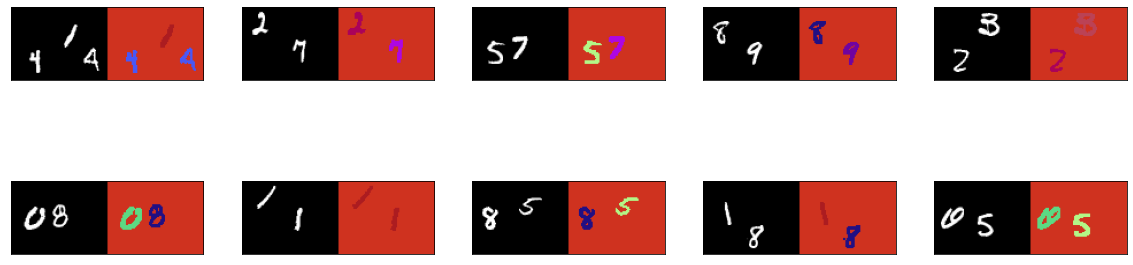

In [5]:
# get 10 images from the training set
list_show_annotation(training_dataset, 10)

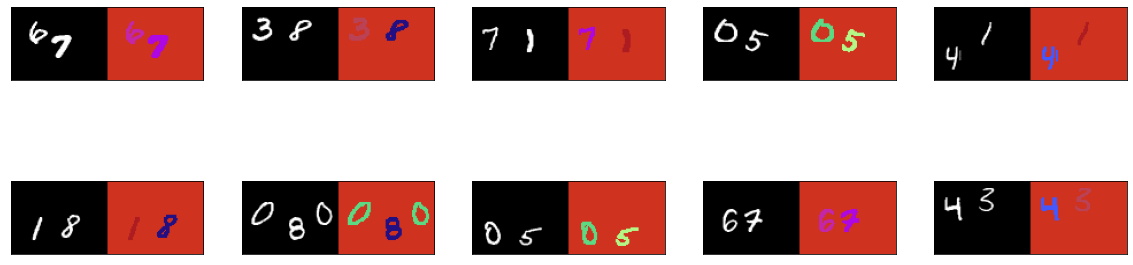

In [6]:
# get 10 images from the validation set
list_show_annotation(validation_dataset, 10)

In [11]:
# parameter describing where the channel dimension is found in our dataset
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, strides, pooling_size, pool_strides):
  '''
  Args:
    input (tensor) -- batch of images or features
    filters (int) -- number of filters of the Conv2D layers
    strides (int) -- strides setting of the Conv2D layers
    pooling_size (int) -- pooling size of the MaxPooling2D layers
    pool_strides (int) -- strides setting of the MaxPooling2D layers
  
  Returns:
    (tensor) max pooled and batch-normalized features of the input 
  '''
  ### START CODE HERE ###
  # use the functional syntax to stack the layers as shown in the diagram above
  x = tf.keras.layers.Conv2D(filters=filters, kernel_size= (3,3), strides =strides, padding='same', data_format=IMAGE_ORDERING)(input)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Conv2D(filters=filters, kernel_size= (3,3), strides =strides, padding='same', data_format=IMAGE_ORDERING)(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=pooling_size, strides=pool_strides, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  ### END CODE HERE ###

  return x

In [12]:
# TEST CODE:

test_input = tf.keras.layers.Input(shape=(64,84, 1))
test_output = conv_block(test_input, 32, 3, 2, 2)
test_model = tf.keras.Model(inputs=test_input, outputs=test_output)

print(test_model.summary())

# free up test resources
del test_input, test_output, test_model

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 84, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 22, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 10, 32)         9248      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 10, 32)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 5, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 5, 32)         

<a name='exercise-2'></a>

#### **Exercise 2**

Now that we've defined the building block of our encoder, you can now build the downsampling path. Please complete the function below to create the encoder. This should chain together five convolution building blocks to create a feature extraction CNN minus the fully connected layers.

*Notes*: 
1. To optimize processing, it is best to resize the images to have dimension sizes in the power of 2. We know that our dataset images have the size 64 x 84. 64 is already a power of 2. 84, on the other hand, is not and needs to be padded to 96. You can refer to the [ZeroPadding2D layer](https://keras.io/api/layers/reshaping_layers/zero_padding2d/) on how to do this. Remember that you will only pad the width (84) and not the height (64).

2. We recommend keeping the pool size and stride parameters constant at 2 

In [18]:
def FCN8(input_height=64, input_width=84):
    '''
    Defines the downsampling path of the image segmentation model.

    Args:
      input_height (int) -- height of the images
      width (int) -- width of the images

    Returns:
    (tuple of tensors, tensor)
      tuple of tensors -- features extracted at blocks 3 to 5
      tensor -- copy of the input
    '''
   
    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1))
    ### START CODE HERE ###
    
    # pad the input image to have dimensions to the nearest power of two
    x = tf.keras.layers.ZeroPadding2D(padding=(0, 6))(img_input) 

    # Block 1
    x = conv_block(input=x, filters=32, strides=1, pooling_size=2, pool_strides=2)
  
    # Block 2
    x = conv_block(input=x, filters=64, strides=1, pooling_size=2, pool_strides=2)
  
    
    # Block 3
    x = conv_block(input=x, filters=128, strides=1, pooling_size=2, pool_strides=2)
    # save the feature map at this stage
    f3 = x

    # Block 4
    x = conv_block(input=x, filters=256, strides=1, pooling_size=2, pool_strides=2)
    # save the feature map at this stage
    f4 = x

    # Block 5
    x = conv_block(input=x, filters=256, strides=1, pooling_size=2, pool_strides=2)
  
    # save the feature map at this stage
    f5 = x

    ### END CODE HERE ###
  
    return (f3, f4, f5), img_input


In [19]:

test_convs, test_img_input = FCN8()
test_model = tf.keras.Model(inputs=test_img_input, outputs=[test_convs, test_img_input])

print(test_model.summary())

del test_convs, test_img_input, test_model

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 84, 1)]       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 96, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 96, 32)        320       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 64, 96, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 96, 32)        9248      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 64, 96, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 48, 32)       

In [20]:
def fcn8_decoder(convs, n_classes):
  # features from the encoder stage
  f3, f4, f5 = convs

  # number of filters
  n = 512

  # add convolutional layers on top of the CNN extractor.
  o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING)(f5)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o)

    
  ### START CODE HERE ###

  # Upsample `o` above and crop any extra pixels introduced
  o = tf.keras.layers.Conv2DTranspose(
               n_classes, kernel_size=(4, 4),
               strides=(2, 2),
               use_bias=False)(f5)
  o = tf.keras.layers.Cropping2D(
               cropping=(1, 1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = tf.keras.layers.Conv2D(
               n_classes,
               (1, 1),
               activation='relu',
               padding='same')(f4)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = tf.keras.layers.Conv2DTranspose(
              n_classes, (4, 4),
              strides=(2, 2),
              use_bias=False)(o)
  o = tf.keras.layers.Cropping2D(
             cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(
            n_classes,
            (8, 8),
            strides=(8, 8),
            use_bias=False)(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(o)

  # append a sigmoid activation
  o = (tf.keras.layers.Activation('sigmoid'))(o)
  ### END CODE HERE ###

  return o

In [21]:
# TEST CODE

test_convs, test_img_input = FCN8()
test_fcn8_decoder = fcn8_decoder(test_convs, 11)

print(test_fcn8_decoder.shape)

del test_convs, test_img_input, test_fcn8_decoder

(None, 64, 84, 11)


In [22]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
dec_op = fcn8_decoder(convs, n_classes)

# define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

In [23]:
sgd = tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True)
### START CODE HERE ###
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
### END CODE HERE ###

In [31]:
### START CODE HERE ###
EPOCHS = 200
### END CODE HERE ###

steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE


history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0472 - accuracy: 0.9669 - val_loss: 0.0652 - val_accuracy: 0.9637
Epoch 2/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0470 - accuracy: 0.9670 - val_loss: 0.0648 - val_accuracy: 0.9637
Epoch 3/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0469 - accuracy: 0.9670 - val_loss: 0.0657 - val_accuracy: 0.9636
Epoch 4/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0468 - accuracy: 0.9670 - val_loss: 0.0655 - val_accuracy: 0.9637
Epoch 5/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0468 - accuracy: 0.9670 - val_loss: 0.0637 - val_accuracy: 0.9640
Epoch 6/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0466 - accuracy: 0.9671 - val_loss: 0.0646 - val_accuracy: 0.9639
Epoch 7/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0465 - accuracy: 0.9671 - val_loss: 0.0652 - val_accuracy:

125/125 [==============================] - 2s 17ms/step - loss: 0.0427 - accuracy: 0.9680 - val_loss: 0.0612 - val_accuracy: 0.9648
Epoch 58/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0427 - accuracy: 0.9680 - val_loss: 0.0622 - val_accuracy: 0.9645
Epoch 59/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0426 - accuracy: 0.9680 - val_loss: 0.0620 - val_accuracy: 0.9646
Epoch 60/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0425 - accuracy: 0.9680 - val_loss: 0.0641 - val_accuracy: 0.9644
Epoch 61/200
125/125 [==============================] - 2s 17ms/step - loss: 0.0425 - accuracy: 0.9680 - val_loss: 0.0623 - val_accuracy: 0.9647
Epoch 62/200
125/125 [==============================] - 2s 17ms/step - loss: 0.0424 - accuracy: 0.9680 - val_loss: 0.0631 - val_accuracy: 0.9644
Epoch 63/200
125/125 [==============================] - 2s 17ms/step - loss: 0.0423 - accuracy: 0.9680 - val_loss: 0.0615 - val_accuracy: 0.964

125/125 [==============================] - 2s 18ms/step - loss: 0.0400 - accuracy: 0.9686 - val_loss: 0.0598 - val_accuracy: 0.9652
Epoch 114/200
125/125 [==============================] - 2s 17ms/step - loss: 0.0399 - accuracy: 0.9686 - val_loss: 0.0618 - val_accuracy: 0.9650
Epoch 115/200
125/125 [==============================] - 2s 17ms/step - loss: 0.0399 - accuracy: 0.9686 - val_loss: 0.0610 - val_accuracy: 0.9651
Epoch 116/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0398 - accuracy: 0.9686 - val_loss: 0.0596 - val_accuracy: 0.9653
Epoch 117/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0398 - accuracy: 0.9687 - val_loss: 0.0607 - val_accuracy: 0.9651
Epoch 118/200
125/125 [==============================] - 2s 17ms/step - loss: 0.0398 - accuracy: 0.9687 - val_loss: 0.0604 - val_accuracy: 0.9652
Epoch 119/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0397 - accuracy: 0.9687 - val_loss: 0.0607 - val_accuracy:

125/125 [==============================] - 2s 17ms/step - loss: 0.0377 - accuracy: 0.9697 - val_loss: 0.0599 - val_accuracy: 0.9659
Epoch 170/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0376 - accuracy: 0.9697 - val_loss: 0.0617 - val_accuracy: 0.9656
Epoch 171/200
125/125 [==============================] - 2s 18ms/step - loss: 0.0376 - accuracy: 0.9697 - val_loss: 0.0589 - val_accuracy: 0.9660
Epoch 172/200
125/125 [==============================] - 2s 17ms/step - loss: 0.0376 - accuracy: 0.9697 - val_loss: 0.0597 - val_accuracy: 0.9659
Epoch 173/200
125/125 [==============================] - 2s 17ms/step - loss: 0.0376 - accuracy: 0.9697 - val_loss: 0.0593 - val_accuracy: 0.9660
Epoch 174/200
125/125 [==============================] - 2s 17ms/step - loss: 0.0375 - accuracy: 0.9697 - val_loss: 0.0601 - val_accuracy: 0.9659
Epoch 175/200
125/125 [==============================] - 2s 17ms/step - loss: 0.0375 - accuracy: 0.9697 - val_loss: 0.0599 - val_accuracy:

In [25]:
results = model.predict(test_dataset, steps=test_steps)

print(results.shape)

(192, 64, 84, 11)


In [26]:
results = np.argmax(results, axis=3)

print(results.shape)

(192, 64, 84)


### Metrics

We showed in the lectures two ways to evaluate your predictions. The *intersection over union (IOU)* and the *dice score*. Recall that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

The code below does that for you as you've also seen in the ungraded lab. A small smoothing factor is introduced in the denominators to prevent possible division by zero.

In [27]:
print(results[0,0,0])

# prediction map for image 0
print(results[0,:,:])

10
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


In [28]:
def class_wise_metrics(y_true, y_pred):
  '''
  Computes the class-wise IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label maps
    y_pred (tensor) - predicted label maps
  '''
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score


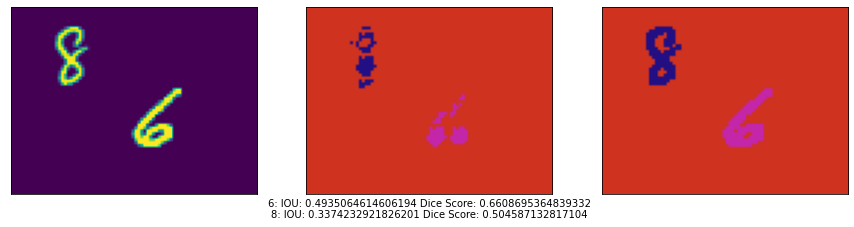

In [29]:
# place a number here between 0 to 191 to pick an image from the test set
integer_slider = 105

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image
  
  
iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])  
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)


In [30]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score)) 
  average_iou += iou

grade = average_iou * 10

print("\nGrade is " + str(grade))

PASSING_GRADE = 60
if (grade>PASSING_GRADE):
  print("You passed!")
else:
  print("You failed. Please check your model and re-train")

Digit 0: IOU: 0.4356275296589028 Dice Score: 0.6068809919832138
Digit 1: IOU: 0.41971296934819124 Dice Score: 0.5912645420727359
Digit 2: IOU: 0.39676556371988625 Dice Score: 0.5681204835308431
Digit 3: IOU: 0.39937200897223085 Dice Score: 0.570787476684702
Digit 4: IOU: 0.3734439825869317 Dice Score: 0.5438066456609848
Digit 5: IOU: 0.34793089524320836 Dice Score: 0.5162444105570129
Digit 6: IOU: 0.4105705700773927 Dice Score: 0.5821340368030877
Digit 7: IOU: 0.4472619781467611 Dice Score: 0.618080188521896
Digit 8: IOU: 0.3732165554835195 Dice Score: 0.5435654762436318
Digit 9: IOU: 0.3797961625003055 Dice Score: 0.5505105360085699

Grade is 39.8369821573733
You failed. Please check your model and re-train


In [ ]:
model.save("model.h5")

In [ ]:
# You can also use this cell as a shortcut for downloading your model
#from google.colab import files
#files.download("model.h5")